## Design the A/B test

In [102]:
import numpy as np

## can also use a bernoulli distribution with p = ctr in measure_click instead of a uniform and threshold
def measure_click(ctr):
    return 1 if np.random.uniform(0,1) < ctr else 0 #A

## simulates a click since measure_click returns 1 indicating a click with probability ctr
def measure_A(): 
    return measure_click(ctr=.0050) #B

def measure_B():
    return measure_click(ctr=.0070) #B

def design_ab_test():
    def pilot_study(num_pilot_measurements):
        clicked_pre_A = np.array([measure_A() for _ in range(num_pilot_measurements)]) 
        clicked_pre_B = np.array([measure_B() for _ in range(num_pilot_measurements)]) 
        print(sum(clicked_pre_A))
        print(sum(clicked_pre_B))
        SD1 = np.sqrt( clicked_pre_A.std()**2 + clicked_pre_B.std()**2 )
        return SD1

    SD1 = pilot_study(1000) #A 
    PS = .001 #B 
    N=(2.8*SD1/PS)**2 #C 
    return int(N)

np.random.seed(1) 
N = design_ab_test()
print('Total number of measurements to take for A and B is',N)

6
5
Total number of measurements to take for A and B is 85761


## Run the A/B test

In [103]:
def run_ab_test(N):
    clicked_A = []
    clicked_B = []
    for n in range(2*N):
        if np.random.uniform(0,1) < .5: #A
            clicked = measure_A() #B
            clicked_A.append(clicked) #C 
        else:
            clicked = measure_B() #B 
            clicked_B.append(clicked) #C
    clicked_A = np.array(clicked_A) 
    clicked_B = np.array(clicked_B)

    return clicked_A, clicked_B

cA, cB = run_ab_test(10000)
print(f'A was clicked {sum(cA)} and B was clicked {sum(cB)}')

A was clicked 50 and B was clicked 66


In [104]:
def analyze_a_b_test(clicked_A, clicked_B): 
    mean_A = clicked_A.mean()
    mean_B = clicked_B.mean()
    std_A = clicked_A.std()
    std_B = clicked_B.std()
    m = mean_B - mean_A #A
    SE = np.sqrt( (std_A**2 + std_B**2) / N ) #A 
    t_stat = np.abs(m / SE) #B
    return t_stat

In [105]:
N = design_ab_test()
clicked_A, clicked_B = run_ab_test(N)
t_stat = analyze_a_b_test(clicked_A, clicked_B)
print('t statistic is ',t_stat)

4
13
t statistic is  6.444217182900364


In [106]:
def ab_test(N):
    sum_clicks = 0.0
    num_ads = 0.0
    sum_A = 0.0
    num_A = 0
    sum_B = 0.0
    num_B = 0
    ctr_vs_n = []
    ctr_A = []
    ctr_B = []
    
    for n in range(2*N):
        if np.random.uniform(0,1) < .5: 
            clicked = measure_A()
            sum_A += clicked #C 
            num_A += 1 #C
        else:
            clicked = measure_B()
            sum_B += clicked    #C
            num_B += 1    #C
            
        sum_clicks += clicked #A 
        num_ads += 1 #B
        if num_A > 0 and num_B > 0:
            ctr_A.append(sum_A/num_A) #D 
            ctr_B.append(sum_B/num_B) #D 
            ctr_vs_n.append(sum_clicks/num_ads) #D
        
    return ctr_vs_n, ctr_A, ctr_B

cn, cA, cB = ab_test(N)

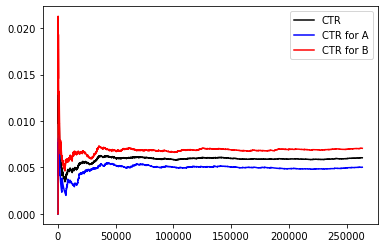

In [107]:
from matplotlib import pyplot as plt
plt.plot(cn, color='black', label='CTR')
plt.plot(cA, color='blue', label='CTR for A')
plt.plot(cB, color='red', label='CTR for B')
plt.legend()

## Epsilon greedy

In [108]:
def epsilon_greedy(N, epsilon): 
    sum_clicks = 0.0
    num_ads = 0.0
    sum_A = 0.0
    num_A = 0
    sum_B = 0.0
    num_B = 0
    ctr_vs_n = []
    
    BM_max = .01
    PS = .001 
    c=5
    epsilon0 = 2*c*(BM_max/PS)**2 #B 
    epsilon_stop = .01

    
    for _ in range(int(2*N)): #A
        select = "Randomize"
        random_val = np.random.uniform(0,1)
        if np.random.uniform(0,1) < 1-epsilon: #B
            ctr_A = sum_A/num_A if num_A>0 else 0 
            ctr_B = sum_B/num_B if num_B>0 else 0

            if ctr_A > ctr_B:
                select = "A"
                clicked = measure_A()
                sum_A += clicked
                num_A += 1
                
            elif ctr_B > ctr_A:
                select = "B"
                clicked = measure_B()
                sum_B += clicked
                num_B += 1
            else:
                if np.random.uniform(0,1) < .5:
                    clicked = measure_A()
                    sum_A += clicked
                    num_A += 1
                else:
                    clicked = measure_B()
                    sum_B += clicked
                    num_B += 1
        else:
            
            if np.random.uniform(0,1) < .5:
                clicked = measure_A()
                sum_A += clicked
                num_A += 1
            else:
                clicked = measure_B()
                sum_B += clicked
                num_B += 1
               
        sum_clicks += clicked 
        num_ads += 1
        ctr_vs_n.append(sum_clicks / num_ads) #D 
        
    return ctr_vs_n

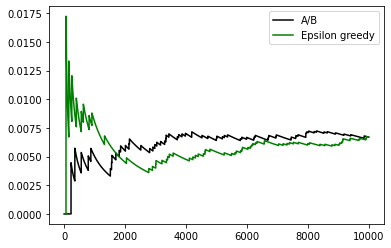

In [109]:
cn, cA, cB = ab_test(5000)
ctr_eps_greedy = epsilon_greedy(5000, 0.1)
plt.plot(cn, color='black', label='A/B')
plt.plot(ctr_eps_greedy, color='green', label='Epsilon greedy')
plt.legend()

## Epsilon Greedy with epsilon decay

In [110]:
def epsilon_greedy_stopping(N, epsilon): 
    sum_clicks = 0.0
    num_ads = 0.0
    sum_A = 0.0
    num_A = 0
    sum_B = 0.0
    num_B = 0
    ctr_vs_n = []
    epsilons = []
    
    BM_max = .01
    PS = .001 
    c=5
    epsilon0 = 2*c*(BM_max/PS)**2 #B 
    epsilon_stop = .01

    n = 0
    
    for _ in range(int(2*N)): #A
        epsilon = min(1.0, epsilon0 / (1.0 + n)) 
        epsilons.append(epsilon)
        
        if epsilon < epsilon_stop: #C
            break
            
        random_val = np.random.uniform(0,1)
        if np.random.uniform(0,1) < 1-epsilon: #B
            ctr_A = sum_A/num_A if num_A>0 else 0 
            ctr_B = sum_B/num_B if num_B>0 else 0

            if ctr_A > ctr_B:
                select = "A"
                clicked = measure_A()
                sum_A += clicked
                num_A += 1
                
            elif ctr_B > ctr_A:
                select = "B"
                clicked = measure_B()
                sum_B += clicked
                num_B += 1
            else:
                if np.random.uniform(0,1) < .5:
                    clicked = measure_A()
                    sum_A += clicked
                    num_A += 1
                else:
                    clicked = measure_B()
                    sum_B += clicked
                    num_B += 1
        else:
            
            if np.random.uniform(0,1) < .5:
                clicked = measure_A()
                sum_A += clicked
                num_A += 1
            else:
                clicked = measure_B()
                sum_B += clicked
                num_B += 1
               
        sum_clicks += clicked 
        num_ads += 1
        n += 1
        ctr_vs_n.append(sum_clicks / num_ads) #D 
        
    return ctr_vs_n, epsilons

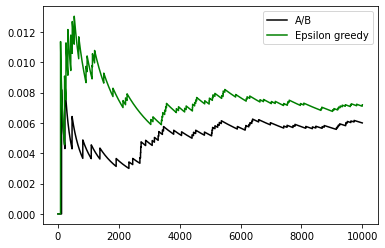

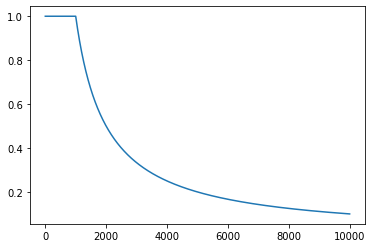

In [111]:
cn, cA, cB = ab_test(5000)
ctr_eps_greedy, epsilons = epsilon_greedy_stopping(5000, 0.1)
plt.plot(cn, color='black', label='A/B')
plt.plot(ctr_eps_greedy, color='green', label='Epsilon greedy')
plt.legend()
plt.figure()
plt.plot(epsilons)

# Ignore all below

## Contextual bandits

In [185]:
class Sample:
    def __init__(self, context, action, reward, user_type):
        self.context = context #A user vector
        self.action = action #B index of post
        self.reward = reward #C reward, could be viewing time or click
        self.user_type = user_type

In [113]:
## Generate two posts
## Generate 140 views with half coming from a distribution of view time A and the other time coming from distribution
## of view time B
## prediction depends on the user and the post, since different users prefer different content
## rewards = f(user, post)
## The user is the context and displaying the post is the action
## Generate random user vectors or context_users and determine the action vectors or beta
## rewards = [context_users] * [beta] + epsilon
## obtain beta so we can verify the results, beta is trying to learn the correct post vector

(array([[ 0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  4.,  8.,  1.,  0.,  0.,  0.],
        [ 0.,  2.,  2.,  8., 11., 11., 11.,  4.,  1.,  0.],
        [ 2.,  2.,  6., 20., 17., 24., 19., 11.,  4.,  1.],
        [ 0.,  2., 12., 23., 50., 52., 36., 23.,  4.,  3.],
        [ 2.,  6., 14., 24., 56., 55., 46., 16.,  9.,  3.],
        [ 1.,  2.,  9., 27., 42., 46., 49., 18., 12.,  0.],
        [ 2.,  0., 10., 11., 25., 24., 20.,  8.,  3.,  1.],
        [ 0.,  1.,  4.,  7., 14., 14., 10.,  5.,  1.,  0.],
        [ 0.,  0.,  1.,  1.,  6.,  9.,  5.,  0.,  1.,  0.]]),
 array([18.44044329, 19.64935463, 20.85826596, 22.0671773 , 23.27608863,
        24.48499997, 25.6939113 , 26.90282264, 28.11173397, 29.32064531,
        30.52955664]),
 array([18.54367647, 19.76878897, 20.99390148, 22.21901398, 23.44412649,
        24.669239  , 25.8943515 , 27.11946401, 28.34457651, 29.56968902,
        30.79480153]),
 <matplotlib.collections.QuadMesh at 0x7fba5a210240>)

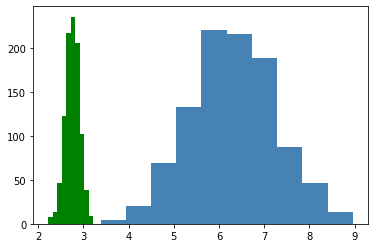

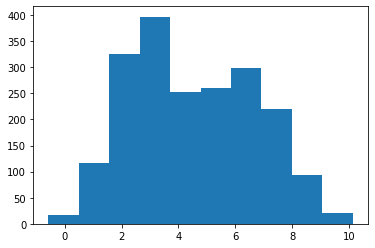

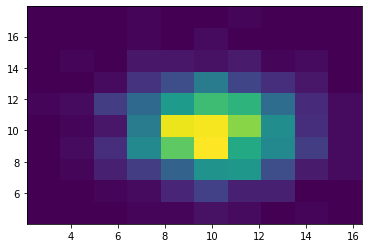

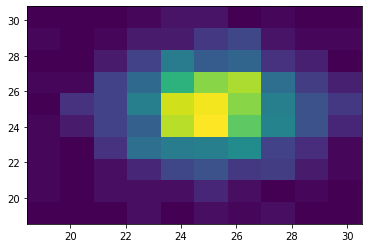

In [178]:
import numpy as np
post_index = [0,1]
n_obs = 1000

## rewards
#reward_a = np.random.lognormal(mean=0.01, sigma=0.1, size=n_obs)
#reward_b = np.random.lognormal(mean=0.4, sigma=0.1, size=n_obs)
#reward_views = np.hstack([reward_a, reward_b])

## beta
beta0 = np.array([0.41, 0.22 ])
beta1 = np.array([0.04, 0.07])

## context vectors 
context_users_a = np.random.normal(loc=10, scale=2, size=[n_obs,2])
context_users_b = np.random.normal(loc=25, scale=2, size=[n_obs,2])
#context_users = np.random.normal(loc=10, scale=5, size=[n_obs*2,2])
context_users = np.vstack([context_users_a, context_users_b])

## compute rewards
reward_a = np.matmul(context_users_a, beta0)
reward_b = np.matmul(context_users_b, beta1)
reward_views = np.hstack([reward_a, reward_b])
reward_views = reward_views + np.random.normal(loc=0, scale=1, size=n_obs*2)

plt.hist(reward_a, color='steelblue')
plt.hist(reward_b, color='green')
plt.figure()
plt.hist(reward_views)
plt.figure()
plt.hist2d(context_users[0:n_obs,0], context_users[0:n_obs,1])
plt.figure()
plt.hist2d(context_users[n_obs:,0], context_users[n_obs:,1])

In [179]:
beta = np.linalg.lstsq(context_users[0 : n_obs], reward_views[0 : n_obs])
print(f"Obtained vector beta {beta[0]}, residual {beta[1]}, rank of beta {beta[2]}, singular values {beta[3]} ")
reward_views - np.dot(context_users, beta[0])

Obtained vector beta [0.41654325 0.21420416], residual [948.02012683], rank of beta 2, singular values [451.99450859  65.300663  ] 


/Users/srajamohan/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


array([  0.21097748,  -1.66482369,  -0.09665703, ..., -11.33980782,
       -12.52684419, -12.86213266])

In [180]:
beta = np.linalg.lstsq(context_users[n_obs: ], reward_views[n_obs: ])
print(f"Obtained vector beta {beta[0]}, residual {beta[1]}, rank of beta {beta[2]}, singular values {beta[3]} ")
reward_views - np.dot(context_users, beta[0])

Obtained vector beta [0.05925873 0.05035868], residual [1023.12454812], rank of beta 2, singular values [1122.07621845   62.57306142] 


/Users/srajamohan/miniconda3/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


array([ 5.17179505,  3.15287047,  4.7964554 , ...,  1.52515741,
        0.42308598, -0.15429951])

### Generate logs

In [186]:
from sklearn.utils import shuffle
shown_post_a = [post_index[0]]*n_obs
shown_post_b = [post_index[1]]*n_obs
shown_post_a.extend(shown_post_b)
actions = shown_post_a

user_type_array = [0]*n_obs
user_type_array.extend([1]*n_obs)
logs = []

def shuffle_lists(a, b, c, d):
    res = shuffle(a, b, c, d)
    return(res[0], res[1], res[2], res[3])
    
shuffled_context_users, shuffled_actions, shuffled_reward_views, shuffled_user_type_array = \
        shuffle_lists(context_users, actions, reward_views, user_type_array)
    
for elem in zip(shuffled_context_users, shuffled_actions, shuffled_reward_views, shuffled_user_type_array):
        logs.append(Sample(elem[0], elem[1], elem[2], elem[3]))

(array([[  0.,   1.,   4.,  28., 100., 236., 297., 220.,  94.,  20.],
        [ 16., 115., 321., 369., 153.,  25.,   1.,   0.,   0.,   0.]]),
 array([-0.574152  ,  0.4964226 ,  1.56699719,  2.63757178,  3.70814638,
         4.77872097,  5.84929556,  6.91987015,  7.99044475,  9.06101934,
        10.13159393]),
 <a list of 2 BarContainer objects>)

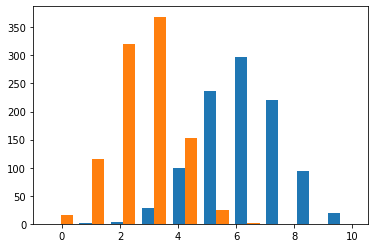

In [187]:
from sklearn.utils import shuffle

def collect_logs_by_action(num_actions, logs): 
    samples_y = [[] for _ in range(num_actions)] 
    samples_x = [[] for _ in range(num_actions)] 
    for sample in logs:
            samples_y[sample.action].append(sample.reward) #A
            samples_x[sample.action].append(sample.context) #A 
    return samples_y, samples_x


samples_y, samples_x = collect_logs_by_action(2, logs)

## the distribution should match that of the rewards generated and seen before
plt.hist(samples_y)

In [188]:
from sklearn.linear_model import SGDRegressor

def build_models(num_features, samples_y, samples_x, solve): 
    betas = []
    for y, x in zip(samples_y, samples_x): 
        if(solve == 'PINV'):
            y = np.array(y) #A
            x = np.array(x) #A
            
            if len(y) > 0: #B
                beta = np.linalg.pinv(x.T@x) @ x.T@y #C 
            else:
                beta = np.zeros(shape=(num_features,)) 
                
            print("From model solve ",len(x), len(y), beta)
        else:
            sgd = SGDRegressor(max_iter=1000, tol=1e-3)
            res = sgd.fit(x, y)
            beta = res.coef_
            
        betas.append(beta) #D
    return betas

### Contextual bandits - Greedy Recommender

In [120]:
class RecommenderGreedy:
    def __init__(self, num_features, num_actions):
        self._num_features = num_features 
        self._num_actions = num_actions
        
    def reset(self): #A
        self._betas = [np.random.normal(size=(self._num_features, ))for _ in range(self._num_actions)]
        
    def fit_offline(self, logs): #B
        samples_y, samples_x = collect_logs_by_action(self._num_actions, logs) 
        self._betas = build_models(self._num_features, samples_y, samples_x, solve='PINV')
  
    def build_models_online(self, num_features, samples_y, samples_x): 
        betas = []
        for y, x in zip(samples_y, samples_x): 
            sgd = SGDRegressor(max_iter=1000, tol=1e-3)
            for i in range(5):
                res = sgd.partial_fit(x, y)
                
            beta = res.coef_
            betas.append(beta) #D
            
        return betas

    def fit_online(self, logs): #B
        samples_y, samples_x = collect_logs_by_action(self._num_actions, logs) 
        self._betas = self.build_models_online(self._num_features, samples_y, samples_x)
        
    def policy(self, context): #C 
        viewing_max = -np.inf
        for action in range(self._num_actions):
            viewing_hat = context @ self._betas[action] #D 
            if viewing_hat > viewing_max: #E
                action_best = action
                viewing_max = viewing_hat 
        return(action_best, viewing_hat)
    
rg = RecommenderGreedy(2,2)
rg.reset()
rg.fit_offline(logs[0:20])

From model solve  11 11 [ 0.6908557  -0.06355308]
From model solve  9 9 [ 0.15942854 -0.04409254]


In [121]:
def evaluate_model():
    post_selected = []
    viewing_times = []
    for i in range(20,30):
        a, b = rg.policy(context_users[i])
        post_selected.append(a)
        viewing_times.append(b)

    print(np.sum(post_selected), len(post_selected))
    print(np.mean(viewing_times))
    return(np.mean(viewing_times))
    
    
evaluate_model()

0 10
1.3130558083954387


1.3130558083954387

0 10
-1034499354482.7467
10 10
1181103526031.7024
0 10
-477300721894.35236
10 10
1288041280356.3257
10 10
578589574336.3481
0 10
-468798322725.98584
0 10
-868357509063.1277
0 10
-387856406487.0332
0 10
-665384739644.0709
10 10
948934673819.055
10 10
1269102124412.0374
10 10
1237263316726.301
10 10
993533082677.8981
10 10
1118478301157.8171
0 10
-1179304017059.5593
10 10
531845287167.98206
10 10
977167818653.2483
0 10
-563469602192.7926
0 10
-1166736096057.686
10 10
955487976155.2405
0 10
-1337732792707.478
10 10
1402277931714.9683
10 10
1509776964264.112
10 10
298542566691.0769
10 10
1357099208837.0693
0 10
-515292926871.2827
10 10
619599116427.1497
0 10
-736024323490.0046
0 10
-608688590090.8914
10 10
731847038828.1119
10 10
1124019300945.3252
10 10
741241629912.7361
10 10
679288217116.1116
10 10
939029455778.7253
0 10
-1206584830993.9146
10 10
861618378279.6523
0 10
-935857407425.7229
0 10
-1018842846192.0635
0 10
-1276924912094.3152
10 10
771383481290.3076
0 10
-1109234331560.716
0 

(array([7., 4., 7., 4., 1., 1., 5., 6., 8., 6.]),
 array([-1.33773279e+12, -1.05298182e+12, -7.68230841e+11, -4.83479866e+11,
        -1.98728890e+11,  8.60220858e+10,  3.70773061e+11,  6.55524037e+11,
         9.40275013e+11,  1.22502599e+12,  1.50977696e+12]),
 <BarContainer object of 10 artists>)

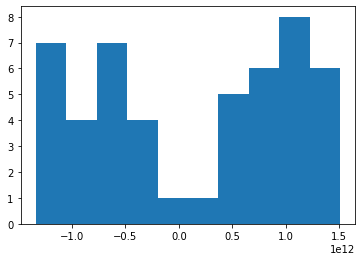

In [122]:
rewards = []
batch_size = 20
for i in range(30, 1000, batch_size):
    rg.fit_online(logs[i: i+batch_size])
    rewards.append(evaluate_model())

print(np.quantile(rewards, q=[0.25, 0.5, 0.75]))
plt.hist(rewards)


### Contextual Bandits - Epsilon Greedy 

In [554]:
logged_events = []

class RecommenderEpsilonGreedy:
    def __init__(self, num_features, num_actions, epsilon):
        self._num_features = num_features 
        self._num_actions = num_actions
        self._epsilon = epsilon
        
    def reset(self): #A
        self._betas = [np.random.normal(size=(self._num_features, ))for _ in range(self._num_actions)]
        
    def fit_offline(self, logs_accumulated): #B
        samples_y, samples_x = collect_logs_by_action(self._num_actions, logs_accumulated) 
        self._betas = build_models(self._num_features, samples_y, samples_x, solve='PINV')
  
    def build_models_online(self, num_features, samples_y, samples_x): 
        betas = []
        for y, x in zip(samples_y, samples_x): 
            sgd = SGDRegressor(max_iter=1000, tol=1e-5)
            for i in range(20):
                res = sgd.partial_fit(x, y)
                
            print("Parameter updates ",res.n_iter_, res.t_, res.intercept_)
            beta = res.coef_
            betas.append(beta) #D
            
        return betas

    def fit_online(self, logs): #B
        samples_y, samples_x = collect_logs_by_action(self._num_actions, logs) 
        self._betas = self.build_models_online(self._num_features, samples_y, samples_x)
        
    def policy(self, context): #C 
        viewing_max = -np.inf
        if np.random.uniform(0,1) < self._epsilon: #A
            action_best = np.random.randint(0, self._num_actions) #B
            viewing_hat = 0
        else:
            for action in range(self._num_actions):
                viewing_hat = context @ self._betas[action] #D 
                if viewing_hat > viewing_max: #E
                    action_best = action
                    viewing_max = viewing_hat 
        return(action_best)
    
reg = RecommenderEpsilonGreedy(2,2,0.2)
reg.reset()
logged_events = logs[0:5]
reg.fit_offline(logged_events)

From model solve  4 4 [0.21863188 0.39955862]
From model solve  1 1 [0.06732962 0.05881894]


In [555]:
def evaluate_epsilongreedy_model():
    post_selected = []
    viewing_times = []
    for i in range(20,30):
        a, b = reg.policy(context_users[i])
        post_selected.append(a)
        viewing_times.append(b)

    print(np.sum(post_selected), len(post_selected))
    print(np.mean(viewing_times))
    return(np.median(viewing_times))
    
    
def run_epsilongreedy_model(logged_events, batch):
    correct = 0
    incorrect = 0
    rewards_array = []
    for i in batch:
        context = i.context
        user_type = i.user_type
        action = reg.policy(context)
        if(action == user_type):
            reward = i.reward
            correct = correct + 1
        else:
            reward = 0.5
            incorrect = incorrect + 1
            
        logged_events.append(Sample(context=context, action=action, reward=reward, user_type=user_type))
        rewards_array.append(reward)
        
    return(rewards_array, correct, incorrect)

From model solve  51 51 [-0.05157924  0.14306597]
From model solve  4 4 [ 0.18056069 -0.09554985]
[array([-0.05157924,  0.14306597]), array([ 0.18056069, -0.09554985])]
From model solve  82 82 [-0.03999245  0.1279438 ]
From model solve  23 23 [-0.01922939  0.11356574]
[array([-0.03999245,  0.1279438 ]), array([-0.01922939,  0.11356574])]
From model solve  92 92 [-0.13404983  0.22197516]
From model solve  63 63 [-0.04759678  0.16232317]
[array([-0.13404983,  0.22197516]), array([-0.04759678,  0.16232317])]
From model solve  97 97 [-0.22175256  0.30932864]
From model solve  108 108 [0.0009896 0.1090912]
[array([-0.22175256,  0.30932864]), array([0.0009896, 0.1090912])]
From model solve  110 110 [-0.18741542  0.26880117]
From model solve  145 145 [-0.00703601  0.11548368]
[array([-0.18741542,  0.26880117]), array([-0.00703601,  0.11548368])]
From model solve  121 121 [-0.26382583  0.34651082]
From model solve  184 184 [-0.00015491  0.10816826]
[array([-0.26382583,  0.34651082]), array([-0

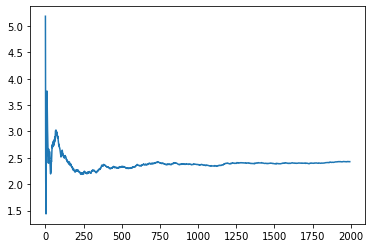

In [556]:
rewards = []
batch_size = 50
total_correct = 0
total_incorrect = 0
for i in range(5, n_obs*2, batch_size):
    rewards_array, correct, incorrect = run_epsilongreedy_model(logged_events, logs[i : i+batch_size])
    total_correct = total_correct + correct
    total_incorrect = total_incorrect + incorrect
    reg.fit_offline(logged_events)
    rewards.extend(rewards_array)
    print(reg._betas)

print(np.mean(rewards))
print(total_correct, total_incorrect)

cumulative_rewards = np.zeros_like(rewards)
for index, reward in enumerate(rewards):
    if(index == 0):
            cumulative_rewards[index] = reward
    else:
            cumulative_rewards[index] = (cumulative_rewards[index - 1]*(index) + reward) / (index + 1)
plt.plot(cumulative_rewards)

In [557]:
beta0

array([0.41, 0.22])

In [558]:
beta1

array([0.04, 0.07])

In [559]:
reward_b.sum() / (n_obs*2)

1.3769320045595639